This is a pretty old notebook from early on. It shows the training process roughly in a step-wise manner. I think I also generated the train-val-test split file
here that I used for the rest of the analysis.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from skimage import io
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import monai
from monai.networks import one_hot
import sys
sys.path.append('./modified_medsam_repo')
from segment_anything import SamPredictor, sam_model_registry, build_sam_vit_b_multiclass
from segment_anything.utils.transforms import ResizeLongestSide
from utils.SurfaceDice import compute_dice_coefficient
from skimage import io, transform
from glob import glob
from sklearn.model_selection import train_test_split
import pandas as pd
import nibabel as nib
import pickle
from torch.utils.data import RandomSampler
from typing import Callable
# set seeds
torch.manual_seed(2023)
np.random.seed(2023)

from MedSAM_HCP.dataset import MRIDataset, load_datasets
from MedSAM_HCP.MedSAM import MedSAM, medsam_inference
from MedSAM_HCP.build_sam import build_sam_vit_b_multiclass
from MedSAM_HCP.utils_hcp import *

### Generate path df and train-val-test split files

In [3]:
data_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/hcp_ya_slices_npy/pretrained_image_encoded_slices'
data_labels_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/hcp_ya_slices_npy/segmentation_slices'
image_path = '/gpfs/data/cbi/hcp/hcp_seg/data_orig'
folder_paths = sorted(glob(os.path.join(data_path, '*')))

In [ ]:
# construct dataframe with all data and slices
# columns:

# ID    Slice #      Path_To_Slice_Npy     Path_To_Slice_Segmentation_Npy     Path_To_Image

# also add columns for the area of each segmentation in the slice

collector_dict = {'id': [], 
                'slice': [], 
                'image_embedding_slice_path': [],
                'segmentation_slice_path': [],
                'image_path': []
}

NUM_CLASSES = 256
region_areas = []
for i, elem in enumerate(tqdm(folder_paths)):
    id = elem.split('/')[-1]
    seg_path = os.path.join(data_labels_path, id)
    for slice_name in os.listdir(elem):
        slice_id = slice_name.split('.')[0]
        
        data_path_this_slice = os.path.join(elem, slice_name)
        seg_path_this_slice = os.path.join(seg_path, f'seg_{slice_name}')

        path_to_overall_image = os.path.join(image_path, id, 'mri', 'T1.mgz')

        collector_dict['id'].append(int(id))
        collector_dict['slice'].append(int(slice_id))
        collector_dict['image_embedding_slice_path'].append(data_path_this_slice)
        collector_dict['segmentation_slice_path'].append(seg_path_this_slice)
        collector_dict['image_path'].append(path_to_overall_image)

        seg_loaded = torch.Tensor(np.load(seg_path_this_slice)).to('cuda') # 256x256 of class indices
        tmp_region_area = []
        for class_num in range(NUM_CLASSES):
            tmp_region_area.append((seg_loaded == class_num).sum().cpu().item())
        region_areas.append(tmp_region_area)

df = pd.DataFrame.from_dict(collector_dict)
df = df.sort_values(by = ['id', 'slice'])
df = df.reset_index(drop=True)

# add the region_areas columns
stacked = np.vstack(region_areas)


#df.to_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df.csv', index=False)

In [10]:
# make version of the dataframe with constant bbox (0,0,256,256)
df_constant_bbox = df
df_constant_bbox['bbox_0'] = 0
df_constant_bbox['bbox_1'] = 0
df_constant_bbox['bbox_2'] = 256
df_constant_bbox['bbox_3'] = 256

df_constant_bbox.to_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_constant_bbox.csv', index=False)

In [25]:
# make version of the dataframe w/ constant bbox and discard 90% of blank images (defined as slice_num <=30 or >=225)
df = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_constant_bbox.csv')
df_trim = df[(30 < df['slice']) & (df['slice'] < 225)]
df_edges = df[(df['slice'] <= 30) | (225 <= df['slice'])]
df_edges_subsampled = df_edges.sample(frac = 0.10, replace=False, random_state=182)
df_edges_subsampled

df_total = pd.concat([df_trim, df_edges_subsampled], axis=0).reset_index()
df_total.to_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_constant_bbox_remove_most_blank.csv', index=False)

In [4]:
ids = [int(x.split('/')[-1]) for x in folder_paths]

# train, val, test split on the id's
size_val = round(0.1 * len(ids))
size_test = round(0.1 * len(ids))

trainval_ids, test_ids = train_test_split(ids, test_size=size_test, random_state = 2023, shuffle=True)
train_ids, val_ids = train_test_split(trainval_ids, test_size=size_val, random_state = 2023, shuffle=True)

# save the id's to a place permanently

dicto = {'train':train_ids, 'val':val_ids, 'test':test_ids}
with open('/gpfs/data/luilab/karthik/pediatric_seg_proj/train_val_test_split.pickle', 'wb') as file:
    pickle.dump(dicto,file)

### Once splits and path_df generated, always begin from here

In [2]:
# load train val test ids
dicto = pickle.load(open('/gpfs/data/luilab/karthik/pediatric_seg_proj/train_val_test_split.pickle', 'rb'))
train_ids = dicto['train']
val_ids = dicto['val']
test_ids = dicto['test']


#sam_model = sam_model_registry['vit_b'](checkpoint=checkpoint).to(device)
# embed_tr_path = join(data_tr_path, 'img_embed')
# os.makedirs(embed_tr_path, exist_ok=True)

# label_id = 1 # liver
# model_type = 'vit_b'
# 
# device = 'cuda:0'
# sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)

In [16]:
path_df = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_constant_bbox.csv')

train_df = path_df[path_df['id'].isin(train_ids)].reset_index(drop=True)
val_df = path_df[path_df['id'].isin(val_ids)].reset_index(drop=True)
test_df = path_df[path_df['id'].isin(test_ids)].reset_index(drop=True)

df_hcp = pd.read_csv('/gpfs/home/kn2347/MedSAM/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/MedSAM/darts_name_class_mapping_processed.csv')
NUM_CLASSES = len(df_desired)
lc = LabelConverter(df_hcp, df_desired)

label_id=None
train_dataset = MRIDataset(train_df, label_id, label_converter=lc, NUM_CLASSES=NUM_CLASSES)
val_dataset = MRIDataset(val_df, label_id, label_converter=lc, NUM_CLASSES=NUM_CLASSES)
test_dataset = MRIDataset(test_df, label_id, label_converter=lc, NUM_CLASSES=NUM_CLASSES)

train_sampler = RandomSampler(train_dataset, replacement=True, num_samples=1024)
val_sampler = RandomSampler(val_dataset, replacement=True, num_samples=128)

train_dataloader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
val_dataloader = DataLoader(val_dataset, batch_size=32, sampler=val_sampler)
#train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
#val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

checkpoint = '/gpfs/home/kn2347/MedSAM/medsam_vit_b.pth'
device = 'cuda:0'
sam_model = build_sam_vit_b_multiclass(num_classes=NUM_CLASSES, checkpoint=checkpoint).to(device)



In [17]:
# %% set up model for fine-tuning 
# train data path
work_dir = '/gpfs/home/kn2347/results/medsam_finetuning_multiclass_model_checkpts_7-25-23'
task_name = 'all_tasks'
# prepare SAM model
model_save_path = join(work_dir, task_name)
os.makedirs(model_save_path, exist_ok=True)
# Set up the optimizer, hyperparameter tuning will improve performance here
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [17]:
def classwise_loss(logits: torch.Tensor, ground_truth: torch.Tensor, num_classes: int, loss_fn: Callable) -> tuple[torch.Tensor, torch.Tensor]:
    # logits: (B, C, H, W) tensor of predicted logits from a model
    # ground_truth: (B, H, W) tensor of class indices forming the ground truth
    # returns: tuple (total_loss as a tensor, tensor of losses for each class with an element for each class)

    loss = 0
    class_losses = []
    for class_num in range(1, num_classes): # skip class 0 when computing loss because it overwhelms the loss signal
            this_label_mask = (ground_truth==class_num).long() # 0 and 1 matrix of size (B, H, W)
            this_loss = loss_fn(logits[:, class_num, :, :], this_label_mask.to(device)) # (B,H,W) and (B,H,W)
            class_losses.append(this_loss)
            loss += this_loss
    class_losses = torch.Tensor(class_losses)
    return (loss, class_losses)

def get_class_index_predictions(logits: torch.Tensor) -> torch.Tensor:
        # logits: (B, C, H, W) tensor of predicted logits from a model
        # returns: tensor of size (B, H, W) containing the maximum probability class for each pixel in each sample

        (prediction_confidences, class_indices) = logits.softmax(dim = 1).max(dim=1) # both are (B, H, W)
        return class_indices

In [26]:
#%% train
num_epochs = 100
losses = []
val_losses = []
best_val_loss = 1e10
sam_model.train()

for epoch in range(num_epochs):
    epoch_loss = 0
    # train
    for step, (image_embedding, seg, boxes, _) in enumerate(tqdm(train_dataloader)):
        # do not compute gradients for image encoder and prompt encoder
        with torch.no_grad():
            B, C, H, W = seg.shape
            # set the bbox as the image size for fully automatic segmentation
            #boxes = torch.from_numpy(np.array([[0,0,W,H]]*B)).float().to(device)
            boxes = boxes.float().to(device)
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=boxes[:, None, :], # expected as (B, 1,)
                masks=None,
            )
        # predicted masks
        mask_predictions, _ = sam_model.mask_decoder(
            image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=True,
        )

        #class_indices = get_class_index_predictions(mask_predictions)

        loss = seg_loss(mask_predictions, seg.to('cuda'))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= (step+1)
    losses.append(epoch_loss)

    # calculate validation loss
    print('Validation')
    val_epoch_loss = 0
    for step, (image_embedding, seg, boxes, _) in enumerate(tqdm(val_dataloader)):
        with torch.no_grad():
            B, C, H, W = seg.shape
            # set the bbox as the image size for fully automatic segmentation
            #boxes = torch.from_numpy(np.array([[0,0,W,H]]*B)).float().to(device)
            boxes = boxes.float().to(device)
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=boxes[:, None, :],
                masks=None,
            )
            # predicted masks
            mask_predictions, _ = sam_model.mask_decoder(
                image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
                image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
                sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
                dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
                multimask_output=True,
            )
            
            #class_indices = get_class_index_predictions(mask_predictions)

            val_loss = seg_loss(mask_predictions, seg.to('cuda'))
            #print(val_class_losses.cpu())
            val_epoch_loss += val_loss.item()
    val_epoch_loss /= (step+1)
    val_losses.append(val_epoch_loss)
    print(f'EPOCH: {epoch}, Train Loss: {epoch_loss}, Val Loss: {val_epoch_loss}')
    # save the latest model checkpoint
    torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_latest.pth'))
    # save the best model
    if val_epoch_loss < best_val_loss:
        best_val_loss = epoch_loss
        torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_best.pth'))

100%|██████████| 32/32 [01:57<00:00,  3.66s/it]


Validation


100%|██████████| 4/4 [00:12<00:00,  3.15s/it]


EPOCH: 0, Train Loss: 2.383601553738117, Val Loss: 1.6641938388347626


100%|██████████| 32/32 [01:59<00:00,  3.72s/it]


Validation


100%|██████████| 4/4 [00:12<00:00,  3.18s/it]


EPOCH: 1, Train Loss: 1.600939903408289, Val Loss: 1.427073448896408


  9%|▉         | 3/32 [00:10<01:38,  3.41s/it]

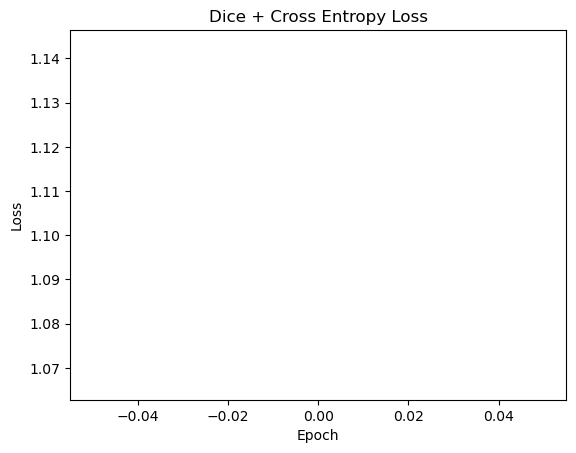

In [140]:
# plot loss
plt.plot(losses)
plt.plot(val_losses, color = 'orange')
plt.title('Dice + Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show() # comment this line if you are running on a server
plt.savefig(join(model_save_path, 'train_loss.png'))
plt.close()

In [156]:
#%% compare the segmentation results between the original SAM model and the fine-tuned model
# load the original SAM model
ori_sam_model = sam_model_registry['vit_b'](checkpoint=checkpoint).to(device)
ori_sam_predictor = SamPredictor(ori_sam_model)


img_idx = np.random.randint(len(test_df))
image_data = test_dataset.load_image(img_idx)
if image_data.shape[-1]>3 and len(image_data.shape)==3:
    image_data = image_data[:,:,:3]
if len(image_data.shape)==2:
    image_data = np.repeat(image_data[:,:,None], 3, axis=-1)
# read ground truth (gt should have the same name as the image) and simulate a bounding box
gt_data = test_dataset[img_idx][1][0,:,:].numpy()
gt_data = (gt_data==label_id).astype(np.uint8)
H, W = gt_data.shape

# predict the segmentation mask using the original SAM model
ori_sam_predictor.set_image(image_data)
ori_sam_seg, _, _ = ori_sam_predictor.predict(point_coords=None, box=np.array([0,0,H,W]), multimask_output=False)

In [157]:
# predict the segmentation mask using the fine-tuned model
# resize image to 3*1024*1024


# resize
sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
resize_img = sam_transform.apply_image(image_data)
resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)

#%% image preprocessing and model inference
#img_1024 = transform.resize(image_data, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)


resize_img_tensor = (resize_img_tensor - resize_img_tensor.min()) / torch.clip(
    resize_img_tensor.max() - resize_img_tensor.min(), min=1e-8, max=None
)  
input_tensor = resize_img_tensor[None, :, : ,:] # (1x3xHxW)
#box_np = np.array([[95,255, 190, 350]])
# transfer box_np t0 1024x1024 scale
#box_1024 = box_np / np.array([W, H, W, H]) * 1024




with torch.no_grad():
    # pre-compute the image embedding
    ts_img_embedding = sam_model.image_encoder(input_tensor)
    box_torch =torch.from_numpy(np.array([[0,0,W,H]])).float().to(device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 4) -> (B, 1, 4)
    
    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    medsam_seg_prob, _ = sam_model.mask_decoder(
        image_embeddings=ts_img_embedding.to(device), # (B, 256, 64, 64)
        image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )
    medsam_seg_prob = torch.sigmoid(medsam_seg_prob)
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

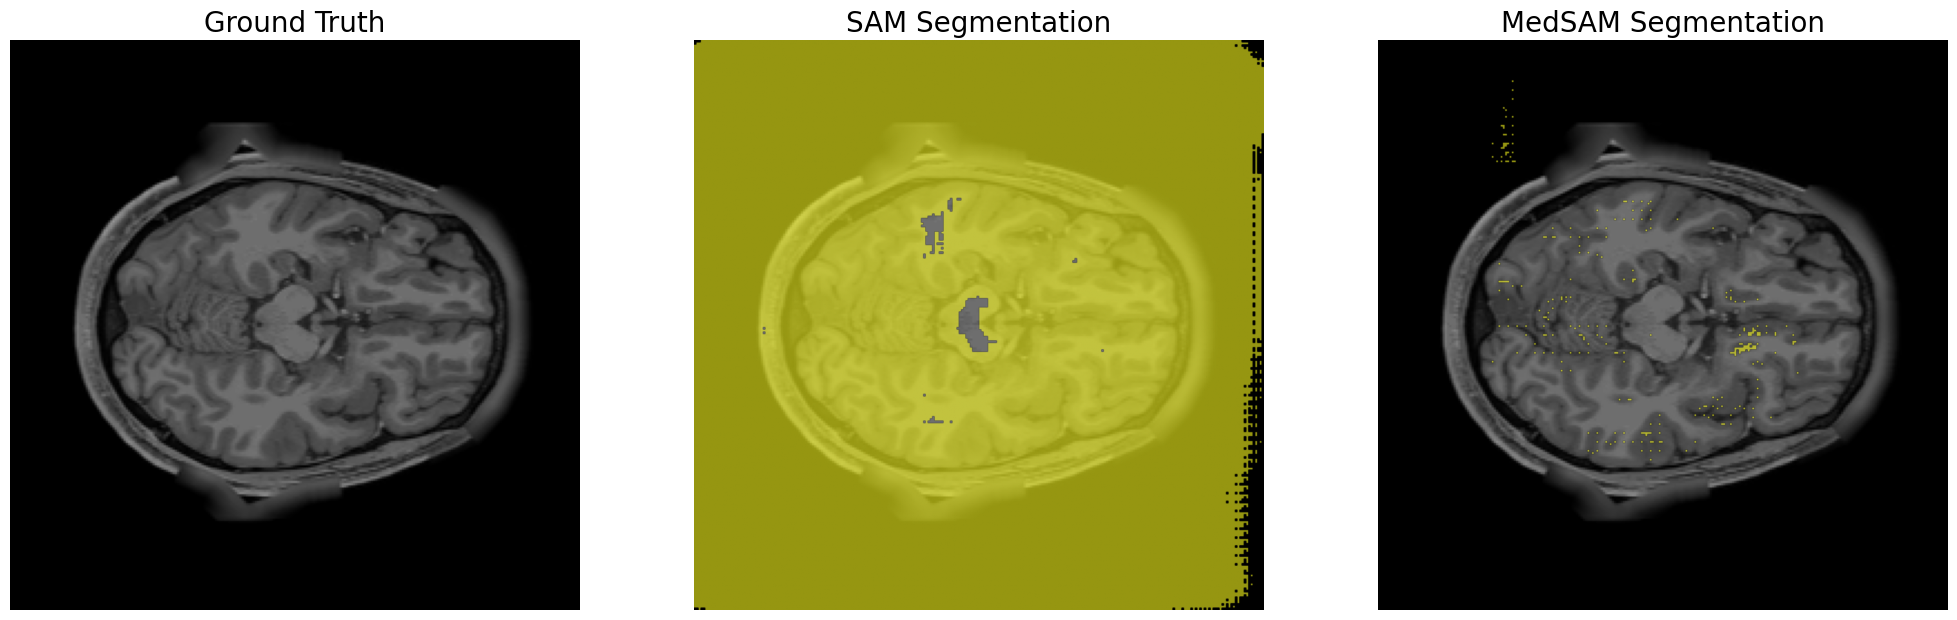

In [158]:
#%% visualize the segmentation results of the middle slice
# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))    

_, axs = plt.subplots(1, 3, figsize=(25, 25))
axs[0].imshow(image_data)
show_mask(gt_data>0, axs[0])
axs[0].set_title('Ground Truth', fontsize=20)
axs[0].axis('off')

axs[1].imshow(image_data)
show_mask(ori_sam_seg, axs[1])
axs[1].set_title('SAM Segmentation', fontsize=20)
axs[1].axis('off')

axs[2].imshow(image_data)
show_mask(medsam_seg, axs[2])
axs[2].set_title('MedSAM Segmentation', fontsize=20)
axs[2].axis('off')
plt.show()  
plt.subplots_adjust(wspace=0.01, hspace=0)
# save plot
# plt.savefig(join(model_save_path, test_npzs[npz_idx].split('.npz')[0] + str(img_id).zfill(3) + '.png'), bbox_inches='tight', dpi=300)
plt.close()